In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
import pyccl.nl_pt as pt
import pyccl.ccllib as lib
from astropy import units as u
from astropy.coordinates import Angle
%pylab inline 
from astropy.table import Table

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/global/common/software/lsst/gitlab/desc-python-dev/2023-09-15-59-44/py/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Preliminaries
Setting up a cosmology and defining the redshift distribution

In [2]:
#OuterRim:
cosmo = ccl.Cosmology(
    Omega_c=0.22, Omega_b=0.0448, 
    h=0.71, sigma8 = 0.801, n_s= 0.963,w0=-1.00,wa=0.0, Omega_k=0.0)
#cosmo-SLICS model-fid:
#cosmo = ccl.Cosmology(
#    Omega_c=0.2458, Omega_b=0.0447, 
#    h=0.6898, sigma8 = 0.836, n_s= 0.969,w0=-1.00,wa=0.0, Omega_k=0.0)

In [3]:
#nzs=np.loadtxt("/global/homes/j/jharno/IA-infusion/SkySim5000/tools/SkySim5000_IA_infusion/StageIV_zcen_nz_bin1-5.dat", unpack = True)
nzs=np.loadtxt("/global/homes/j/jharno/IA-infusion/SkySim5000/tools/SkySim5000_IA_infusion/nz_sources_srd_5bins.txt", unpack = True)

In [4]:
z=nzs[0]
nzs_s=nzs[1:]

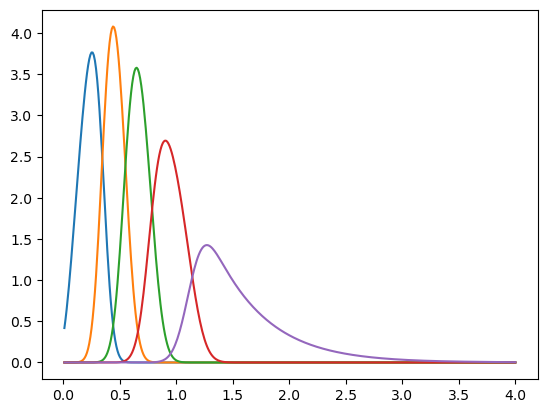

In [5]:
for i in range(len(nzs_s)):
    plot(z,nzs_s[i])

# IA normalization
these factors absorb the typical normalization factors used in the literature for intrinsic alignment amplitude and redshift evolution.

In [6]:
# Biases for IAs. Will be converted to the input c_IA values below.
a_1 = 1.0
a_2 = 0.0
a_d = 2.0

In [7]:
c_1,c_d,c_2 = pt.translate_IA_norm(cosmo, z=z,a1=a_1,a2=a_2, a1delta=a_d, Om_m2_for_c2 = False)

# Tracers
Let's create the 3 PTTracers

In [8]:
# Intrinsic alignments
ptt_i = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1), c2=(z,c_2), cdelta=(z,c_d))
ptt_i_nla = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1)) # to compare using the standard WLTracer

# Matter
ptt_m = pt.PTMatterTracer()


In [9]:
# with_NC (bool) – set to True if you’ll want to use this calculator to compute correlations involving number counts.
# with_IA (bool) – set to True if you’ll want to use this calculator to compute correlations involving intrinsic alignments.

# ptc = pt.PTCalculator(with_NC=True, with_IA=True,
#                       log10k_min=-5, log10k_max=3, low_extrap=-5, high_extrap=3, nk_per_decade=20)
ptc = pt.PTCalculator(with_NC=True, with_IA=True,
                      log10k_min=-5, log10k_max=3, low_extrap=-5, high_extrap=5, nk_per_decade=20)

AttributeError: module 'pyccl.nl_pt' has no attribute 'PTCalculator'

# PT power spectra

In [41]:
# IAs x IAs
pk_ii, pk_ii_bb = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_i, ptc=ptc, return_ia_ee_and_bb=True)
pk_ii_nla = pt.get_pt_pk2d(cosmo, ptt_i_nla, tracer2=ptt_i_nla, ptc=ptc,)

# IAs x matter
pk_im = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_m, ptc=ptc)

# Matter x matter
pk_mm = pt.get_pt_pk2d(cosmo, ptt_m, tracer2=ptt_m, ptc=ptc)

AttributeError: module 'pyccl.nl_pt' has no attribute 'get_pt_pk2d'

In [ ]:
ks = np.logspace(-4,2,512)
ps = {}
ps['ii'] = pk_ii.eval(ks, 1., cosmo)
ps['im'] = pk_im.eval(ks, 1., cosmo)
ps['mm'] = pk_mm.eval(ks, 1., cosmo)

In [ ]:
plt.figure()
for pn, p in ps.items():
    plt.plot(ks, abs(p), label=pn)
plt.loglog()
plt.legend(loc='upper right', ncol=2,
           fontsize=13, labelspacing=0.1)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^{3}]$', fontsize=15)
plt.show()

# Angular power spectra

In [8]:
# Lensing
tracers_len = []

for i in range(len(nzs_s)):
    t_l = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[i]))
    tracers_len.append(t_l)


In [9]:
# Intrinsic alignments
tracers_IA = []
for i in range(len(nzs_s)):
    t_i = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[i]), has_shear=False, ia_bias=(z, np.ones_like(z)), use_A_ia=False)
    tracers_IA.append(t_i)

In [10]:
# Intrinsic alignments
tracers_IA_nla = []
for i in range(len(nzs_s)):
    t_i_nla = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[i]), has_shear=False, ia_bias=(z, np.ones_like(z)), use_A_ia=True)
    tracers_IA_nla.append(t_i_nla)

In [11]:
ell = np.unique(np.geomspace(2,300000,10000).astype(int)).astype(float)

In [12]:
#ell = np.unique(np.geomspace(2,300000,10000).astype(int)).astype(float)
cls={}


cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_len[i], tracers_len[j], ell,p_of_k_a=pk_mm))
cls['GG'] = np.stack(cross)

cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_IA[i], tracers_IA[j], ell,p_of_k_a=pk_ii))
cls['II'] = np.stack(cross)

cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_IA_nla[i], tracers_IA_nla[j], ell))
cls['II,NLA'] = np.stack(cross)


cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_len[i],tracers_IA[j], ell, p_of_k_a=pk_im))
cls['GI'] =np.stack(cross)


cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_len[i],tracers_IA_nla[j], ell))
cls['GI,NLA'] =np.stack(cross)

NameError: name 'pk_mm' is not defined

In [ ]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
        plt.xlabel(r'$\theta$', fontsize=15)
        plt.ylabel(r'$\xi_+(\theta)$', fontsize=15)
    return axs[:N]

In [ ]:
k=ell
figsize = (23, 23)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 3
rows =5
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(cls['GG']))
for ax, pi in zip(axs, cls['GG']):
    ax.loglog(ell, pi,label='No IA')
for ax, px in zip(axs, cls['II,NLA']):
    ax.loglog(ell, px,'--',label='II,NLA')
for ax, pj in zip(axs, cls['II']):
    ax.loglog(ell, pj,'.',label='II')
for ax, pjk in zip(axs, cls['GI']):
    ax.loglog(ell,-pjk,'.',label='-GI')
for ax, pjj in zip(axs, cls['GI,NLA']):
    ax.loglog(ell, -pjj,'.',label='-GI,NLA')

#     plt.xlabel(r'$\ell$', fontsize=15)
#     plt.ylabel(r'$\C_{\ell}(\ell)$', fontsize=15)
# legend(loc='upper right')

# Shear correlation function

In [1]:
theta=np.geomspace(2.0,250,20)

NameError: name 'np' is not defined

In [14]:
theta_arc=Angle(theta,u.arcmin)

In [15]:
theta=theta_arc.deg

In [16]:
shear_GG_plus=[]
for i in range(15): 
    shear_GG_plus.append(ccl.correlation(cosmo, ell, cls['GG'][i] ,theta ,type = 'GG+', method='FFTLog'))
shear_GG_plus=np.stack(shear_GG_plus)

KeyError: 'GG'

In [17]:
shear_GG_minus=[]
for i in range(15): 
    shear_GG_minus.append(ccl.correlation(cosmo, ell, cls['GG'][i] ,theta, type = 'GG-', method='FFTLog'))
shear_GG_minus=np.stack(shear_GG_minus)

KeyError: 'GG'

In [220]:
shear_II_NLA_plus=[]
for i in range(15): 
    shear_II_NLA_plus.append(ccl.correlation(cosmo, ell,cls['II,NLA'][i] ,theta , type = 'GG+', method='FFTLog'))
shear_II_NLA_plus=np.stack(shear_II_NLA_plus)

In [221]:
shear_II_NLA_minus=[]
for i in range(15): 
    shear_II_NLA_minus.append(ccl.correlation(cosmo, ell,cls['II,NLA'][i] ,theta , type = 'GG-', method='FFTLog'))
shear_II_NLA_minus=np.stack(shear_II_NLA_minus)

In [222]:
shear_II_plus=[]
for i in range(15): 
    shear_II_plus.append(ccl.correlation(cosmo, ell,cls['II'][i] ,theta , type = 'GG+', method='FFTLog'))
shear_II_plus=np.stack(shear_II_plus)

In [223]:
shear_II_minus=[]
for i in range(15): 
    shear_II_minus.append(ccl.correlation(cosmo, ell,cls['II'][i] ,theta , type = 'GG-', method='FFTLog'))
shear_II_minus=np.stack(shear_II_minus)

In [224]:
shear_GI_plus=[]
for i in range(15): 
    shear_GI_plus.append(ccl.correlation(cosmo, ell,cls['GI'][i] ,theta , type = 'GG+', method='FFTLog'))
shear_GI_plus=np.stack(shear_GI_plus)

In [225]:
shear_GI_minus=[]
for i in range(15): 
    shear_GI_minus.append(ccl.correlation(cosmo, ell,cls['GI'][i] ,theta , type = 'GG-', method='FFTLog'))
shear_GI_minus=np.stack(shear_GI_minus)

In [226]:
shear_GI_NLA_plus=[]
for i in range(15): 
    shear_GI_NLA_plus.append(ccl.correlation(cosmo, ell,cls['GI,NLA'][i] ,theta , type = 'GG+', method='FFTLog'))
shear_GI_NLA_plus=np.stack(shear_GI_NLA_plus)

In [227]:
shear_GI_NLA_minus=[]
for i in range(15): 
    shear_GI_NLA_minus.append(ccl.correlation(cosmo, ell,cls['GI,NLA'][i] ,theta ,type = 'GG-',method='FFTLog'))
shear_GI_NLA_minus=np.stack(shear_GI_NLA_minus)

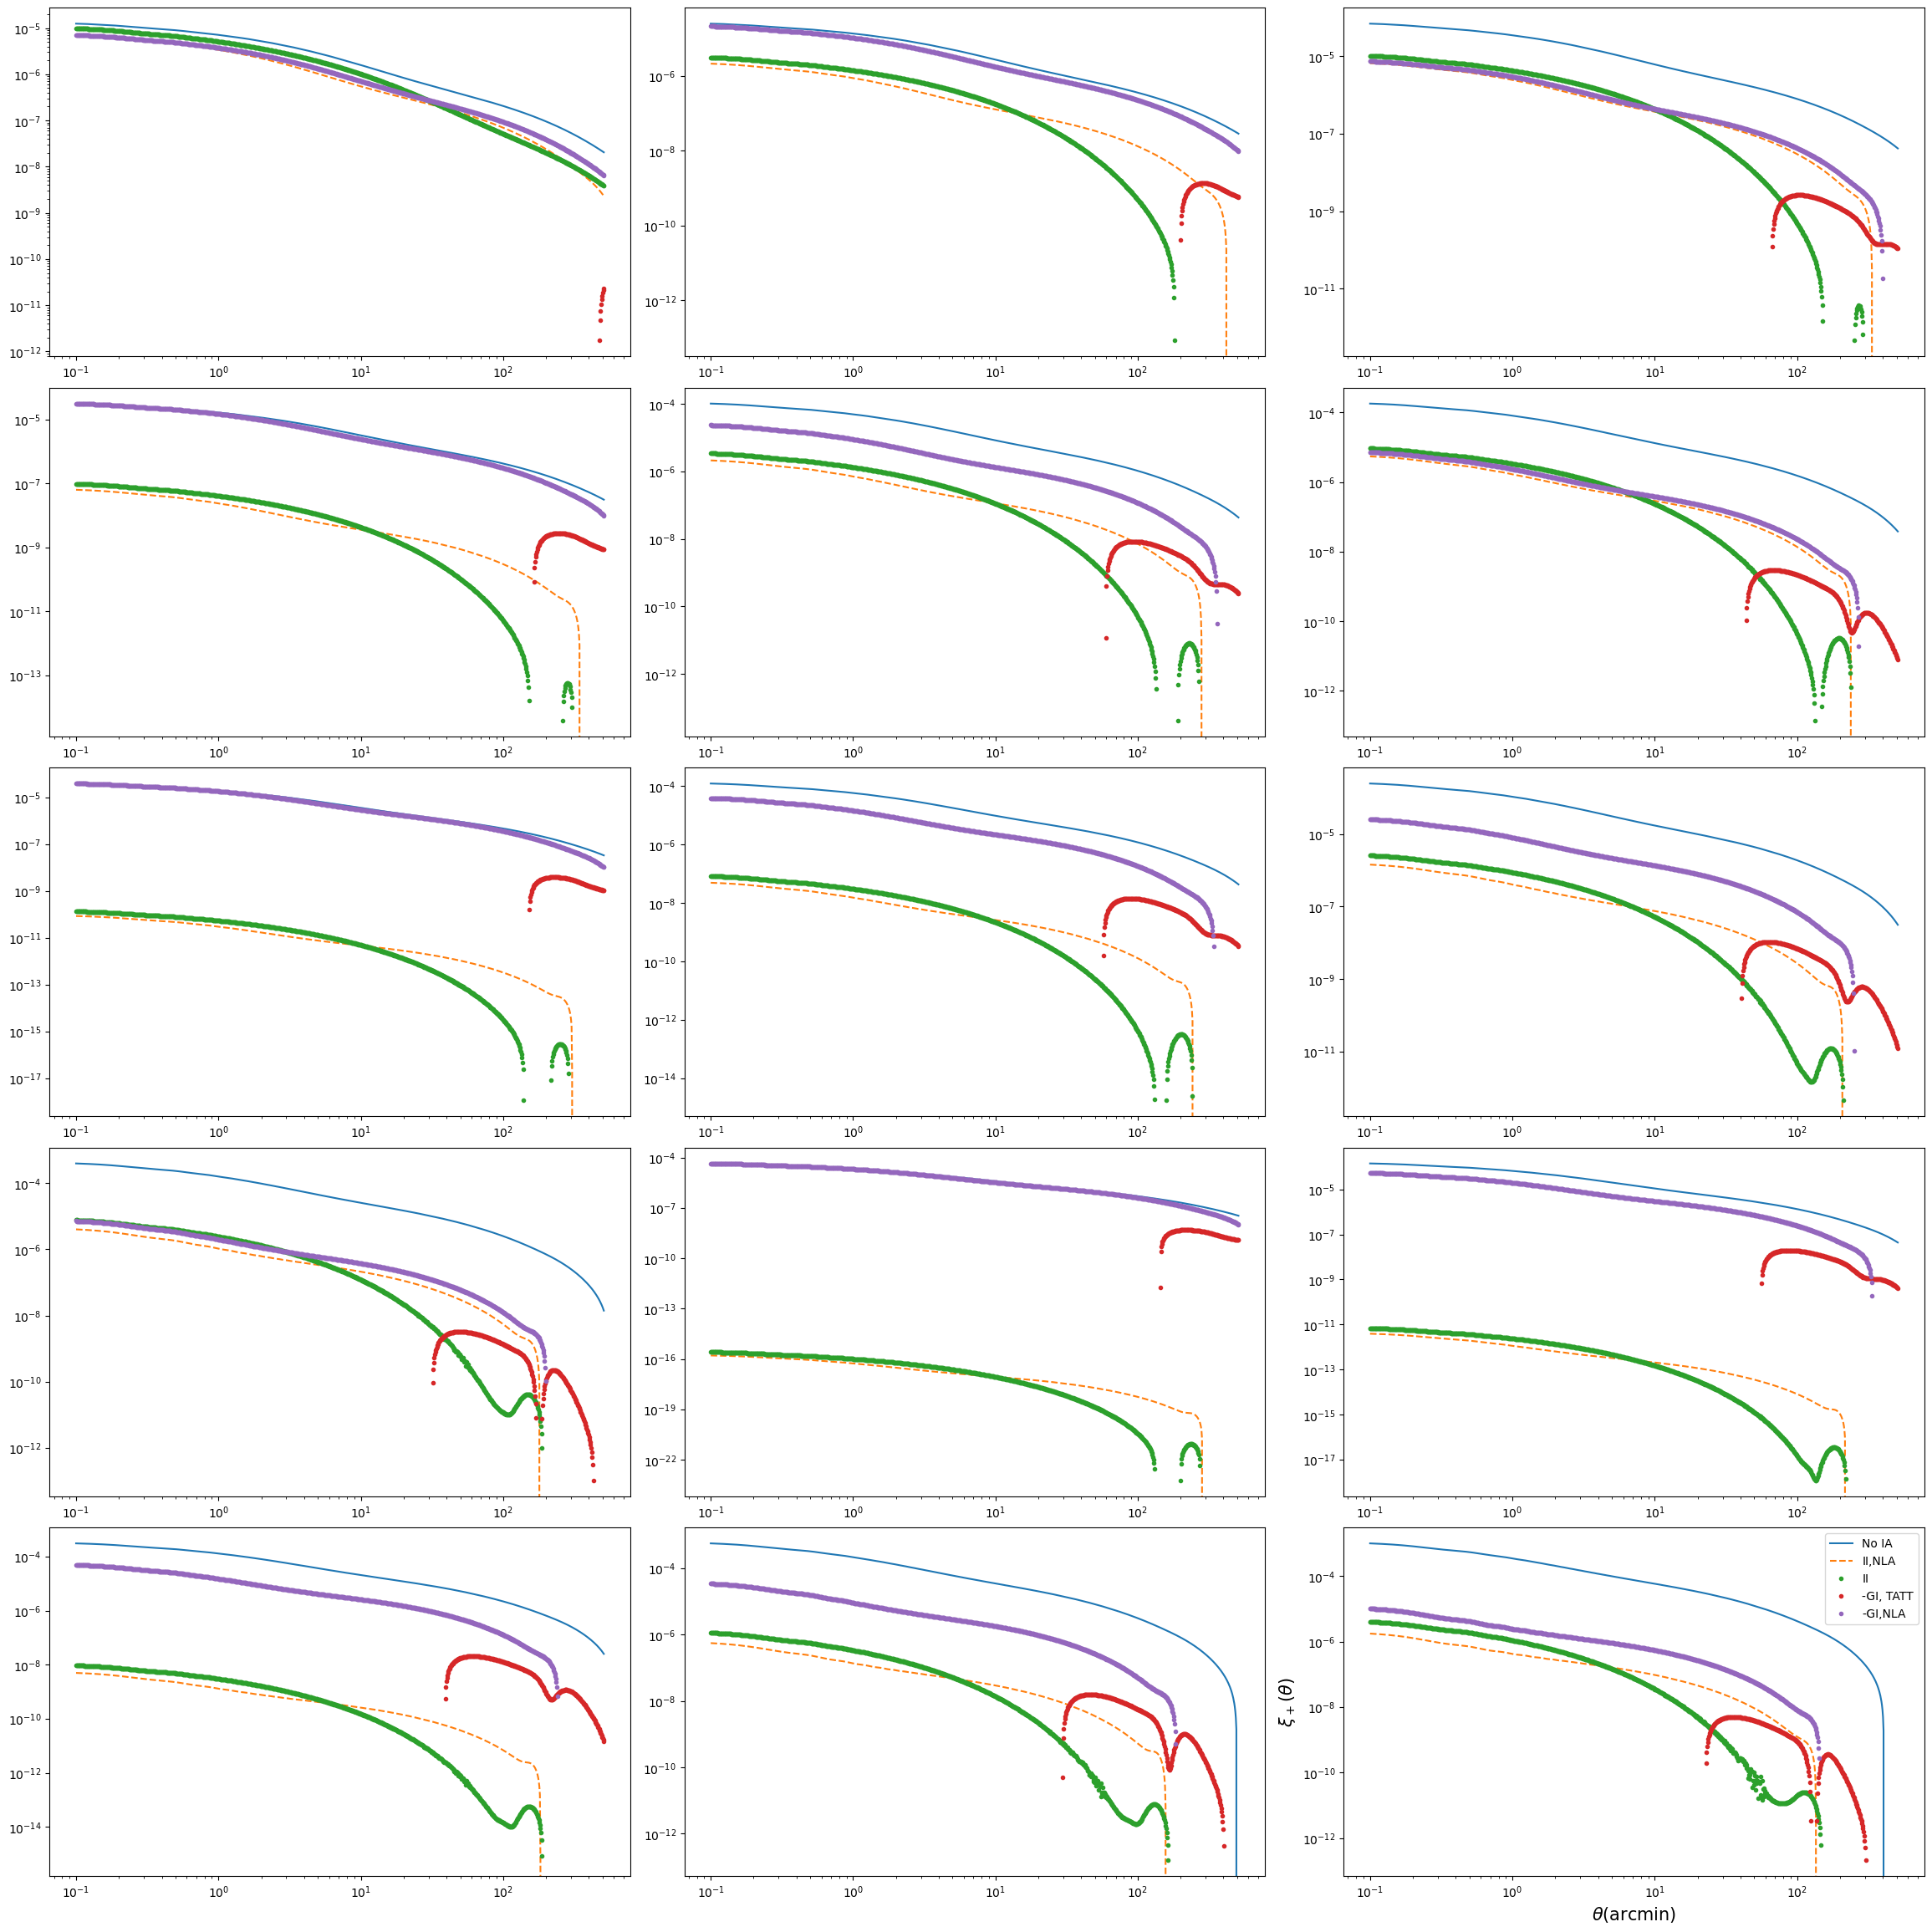

In [228]:
figsize = (23, 23)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 3
rows =5
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(shear_GG_plus))
for ax, pi in zip(axs, shear_GG_plus):
    ax.loglog(theta_arc, pi,label='No IA')
for ax, px in zip(axs, shear_II_NLA_plus):
    ax.loglog(theta_arc, px,'--',label='II,NLA')
for ax, pj in zip(axs, shear_II_plus):
    ax.loglog(theta_arc, pj,'.',label='II')
for ax, pjk in zip(axs, shear_GI_plus):
    ax.loglog(theta_arc,-pjk,'.',label='-GI, TATT')
for ax, pjj in zip(axs, shear_GI_NLA_plus):
    ax.loglog(theta_arc, -pjj,'.',label='-GI,NLA')
    plt.xlabel(r'$\theta$(arcmin)', fontsize=15)
    plt.ylabel(r'$\xi_+(\theta)$', fontsize=15)
xlim()
legend(loc='upper right')
#fig.savefig("pos_cross.png",dpi=250)

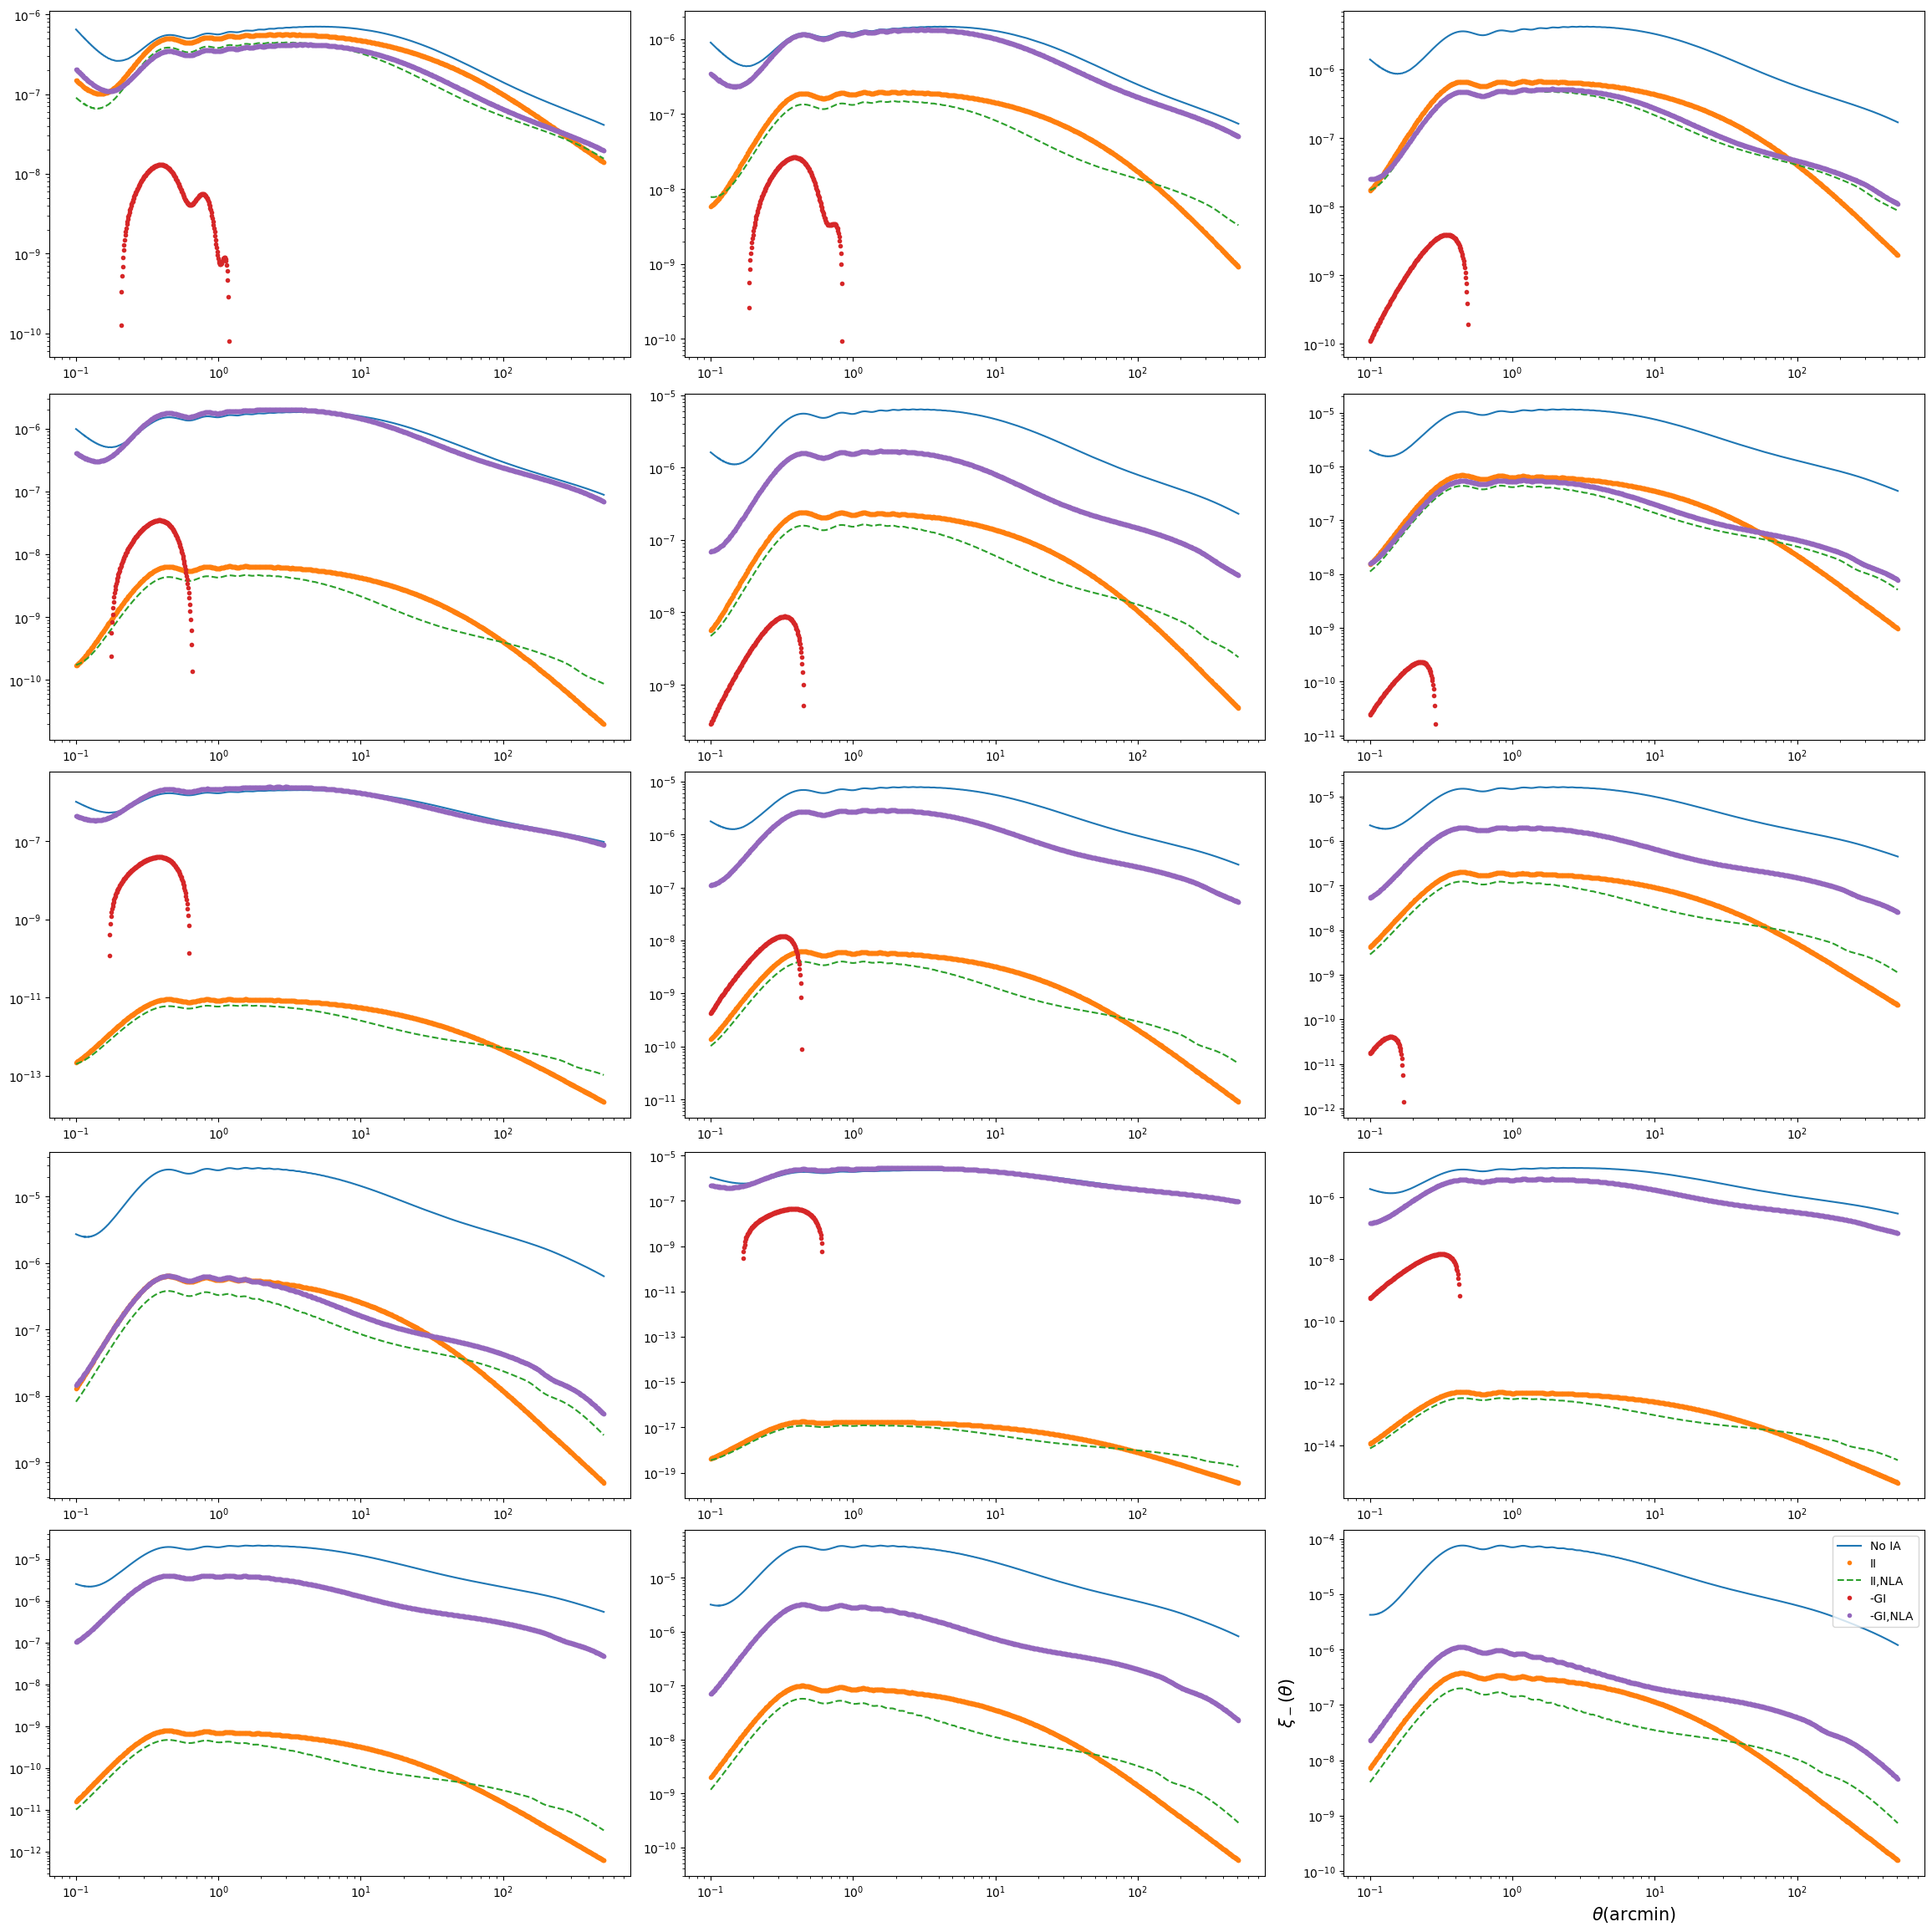

In [229]:

figsize = (23, 23)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 3
rows =5
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(shear_GG_minus))

for ax, pi in zip(axs, shear_GG_minus):
    ax.loglog(theta_arc, pi,label='No IA')
for ax, pj in zip(axs, shear_II_minus):
    ax.loglog(theta_arc, pj,'.',label='II')
for ax, px in zip(axs, shear_II_NLA_minus):
    ax.loglog(theta_arc, px,'--',label='II,NLA')
for ax, pjk in zip(axs, shear_GI_minus):
    ax.loglog(theta_arc,-pjk,'.',label='-GI')
for ax, pjj in zip(axs, shear_GI_NLA_minus):
    ax.loglog(theta_arc, -pjj,'.',label='-GI,NLA')
plt.xlabel(r'$\theta$(arcmin)', fontsize=15)
plt.ylabel(r'$\xi_-(\theta)$', fontsize=15)

legend(loc='upper right')
#fig.savefig("neg_cross.png",dpi=250)

In [230]:
names=('NO IA+','NO IA-','GI+','GI-','GI_NLA+','GI_NLA-','II+','II-','II_NLA+','II_NLA-','theta', 'bin_comb' )

In [231]:
index=[]
for i in range(5):
    for j in range(i+1):
        index.append([i+1,j+1])
index=np.stack(index)

In [232]:
thetax=[]
for i in range(len(shear_GG_plus)):
    thetax.append(theta)

In [233]:
theta=np.stack(thetax)

In [234]:
#Naming convention:
#theo_prediction_[AIA]_[b_TA]_[A2].fits

t = Table([shear_GG_plus,shear_GG_minus, shear_GI_plus,shear_GI_minus,shear_GI_NLA_plus,shear_GI_NLA_minus,shear_II_plus,shear_II_minus,shear_II_NLA_plus,shear_II_NLA_minus,theta,np.stack(index)], names=names)
#t.write('theory/CCL/theo_prediction_0.0_0.0_1.0_V2.fits', format='fits')
#t.write('theory/CCL/theo_prediction_1.0_1.0_1.0_cosmoSLICS_fid.fits', format='fits')
#t.write('theory/CCL/theo_prediction_1.0_1.0_0.0_cosmoSLICS_fid.fits', format='fits')
#t.write('theory/CCL/theo_prediction_1.0_0.0_0.0_cosmoSLICS_fid.fits', format='fits')
#t.write('theory/CCL/theo_prediction_1.0_2.0_0.0_cosmoSLICS_fid.fits', format='fits')
#t.write('theory/CCL/theo_prediction_1.0_0.5_0.0.fits', format='fits', overwrite=True)
#t.write('theory/CCL/theo_prediction_0.0_0.0_m1.0.fits', format='fits', overwrite=True)

#t.write('theory/CCL/theo_prediction_SRD_a1_1.0_bta_0.0_a2_0.0.fits', format='fits', overwrite=True)
#t.write('theory/CCL/theo_prediction_SRD_a1_m1.0_bta_0.0_a2_0.0.fits', format='fits', overwrite=True)
#t.write('theory/CCL/theo_prediction_SRD_a1_1.0_bta_1.0_a2_0.0.fits', format='fits', overwrite=True)
#t.write('theory/CCL/theo_prediction_SRD_a1_1.0_bta_2.0_a2_0.0.fits', format='fits', overwrite=True)
#t.write('theory/CCL/theo_prediction_SRD_a1_0.0_bta_0.0_a2_1.0.fits', format='fits', overwrite=True)
t.write('theory/CCL/theo_prediction_SRD_a1_0.0_bta_0.0_a2_m1.0.fits', format='fits', overwrite=True)




In [54]:
# define the lens samples
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[0,:]))
lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[1,:]))
lens3 = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[2,:]))
lens4 = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[3,:]))
lens5 = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[4,:]))
